In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
work_dir = '/content/drive/MyDrive/DLproject'
img_dir = '/content/drive/MyDrive/DLproject/original_images'
lab_dir = '/content/drive/MyDrive/DLproject/label_images_semantic'

In [ ]:
images = sorted([os.path.join(img_dir, i) for i in os.listdir(img_dir)])
train_images = images[:370] # There are 370 training images
val_images = images[370:390] # There are 20 validation images
test_images = images[390:] # There are 10 test images
print(train_images)

['/content/drive/MyDrive/DLproject/original_images/000.jpg', '/content/drive/MyDrive/DLproject/original_images/001.jpg', '/content/drive/MyDrive/DLproject/original_images/002.jpg', '/content/drive/MyDrive/DLproject/original_images/003.jpg', '/content/drive/MyDrive/DLproject/original_images/004.jpg', '/content/drive/MyDrive/DLproject/original_images/005.jpg', '/content/drive/MyDrive/DLproject/original_images/006.jpg', '/content/drive/MyDrive/DLproject/original_images/008.jpg', '/content/drive/MyDrive/DLproject/original_images/011.jpg', '/content/drive/MyDrive/DLproject/original_images/013.jpg', '/content/drive/MyDrive/DLproject/original_images/014.jpg', '/content/drive/MyDrive/DLproject/original_images/015.jpg', '/content/drive/MyDrive/DLproject/original_images/016.jpg', '/content/drive/MyDrive/DLproject/original_images/018.jpg', '/content/drive/MyDrive/DLproject/original_images/019.jpg', '/content/drive/MyDrive/DLproject/original_images/021.jpg', '/content/drive/MyDrive/DLproject/origi

In [ ]:
labels = sorted([os.path.join(lab_dir, i) for i in os.listdir(lab_dir)])
train_labels = labels[:370] # There are 370 training labels
val_labels = labels[370:390] # There are 20 validation labels
test_labels = labels[390:] # There are 10 test labels
print(train_labels)

['/content/drive/MyDrive/DLproject/label_images_semantic/000.png', '/content/drive/MyDrive/DLproject/label_images_semantic/001.png', '/content/drive/MyDrive/DLproject/label_images_semantic/002.png', '/content/drive/MyDrive/DLproject/label_images_semantic/003.png', '/content/drive/MyDrive/DLproject/label_images_semantic/004.png', '/content/drive/MyDrive/DLproject/label_images_semantic/005.png', '/content/drive/MyDrive/DLproject/label_images_semantic/006.png', '/content/drive/MyDrive/DLproject/label_images_semantic/008.png', '/content/drive/MyDrive/DLproject/label_images_semantic/011.png', '/content/drive/MyDrive/DLproject/label_images_semantic/013.png', '/content/drive/MyDrive/DLproject/label_images_semantic/014.png', '/content/drive/MyDrive/DLproject/label_images_semantic/015.png', '/content/drive/MyDrive/DLproject/label_images_semantic/016.png', '/content/drive/MyDrive/DLproject/label_images_semantic/018.png', '/content/drive/MyDrive/DLproject/label_images_semantic/019.png', '/content

The actual image size is (6000, 4000)


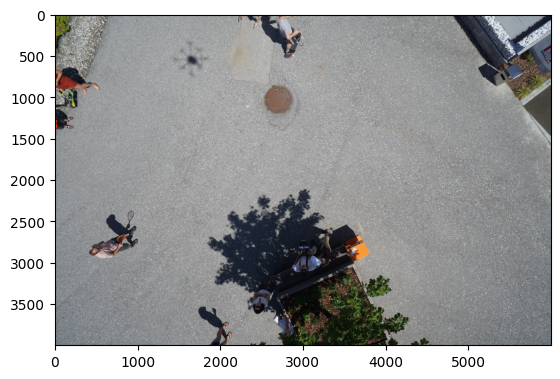

In [ ]:
# Showing one instance of image and its corresponding label
img_path = train_images[0]
image = Image.open(img_path)
print("The actual image size is", image.size)
plt.imshow(image)

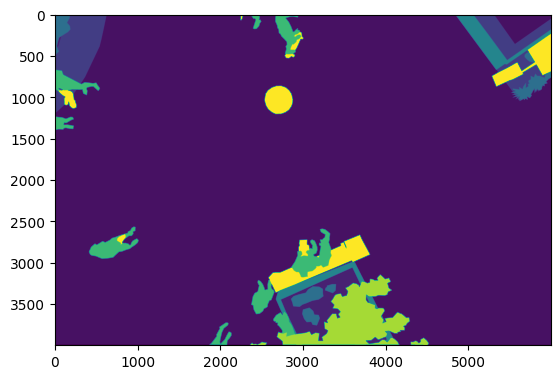

In [ ]:
lab_path = train_labels[0]
lab = plt.imread(lab_path)
plt.imshow(lab)

In [ ]:
BATCH_SIZE = 4
IMAGE_SIZE = 512
NUM_CLASSES = 23
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_labels)
val_dataset = data_generator(val_images, val_labels)
test_dataset = data_generator(test_images, test_labels)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Test Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


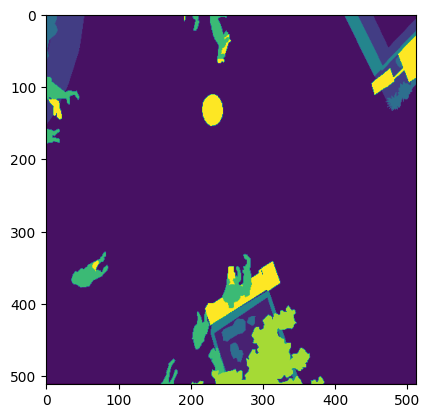

In [ ]:
image = tf.io.read_file(lab_path)
image = tf.image.decode_png(image, channels=1)
image.set_shape([None, None, 1])
image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
plt.imshow(image)

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                         

Epoch 1/50
92/92 [==============================] - 231s 2s/step - loss: 1.4411 - accuracy: 0.5963 - val_loss: 4.2073 - val_accuracy: 0.2416
Epoch 2/50
92/92 [==============================] - 132s 1s/step - loss: 0.9757 - accuracy: 0.7003 - val_loss: 1.5118 - val_accuracy: 0.5395
Epoch 3/50
92/92 [==============================] - 133s 1s/step - loss: 0.8071 - accuracy: 0.7502 - val_loss: 7.4009 - val_accuracy: 0.1501
Epoch 4/50
92/92 [==============================] - 130s 1s/step - loss: 0.6788 - accuracy: 0.7904 - val_loss: 1.6413 - val_accuracy: 0.6344
Epoch 5/50
92/92 [==============================] - 127s 1s/step - loss: 0.5566 - accuracy: 0.8272 - val_loss: 0.8224 - val_accuracy: 0.7352
Epoch 6/50
92/92 [==============================] - 132s 1s/step - loss: 0.4886 - accuracy: 0.8483 - val_loss: 0.5515 - val_accuracy: 0.8344
Epoch 7/50
92/92 [==============================] - 133s 1s/step - loss: 0.4182 - accuracy: 0.8702 - val_loss: 0.7688 - val_accuracy: 0.7594
Epoch 8/50
92

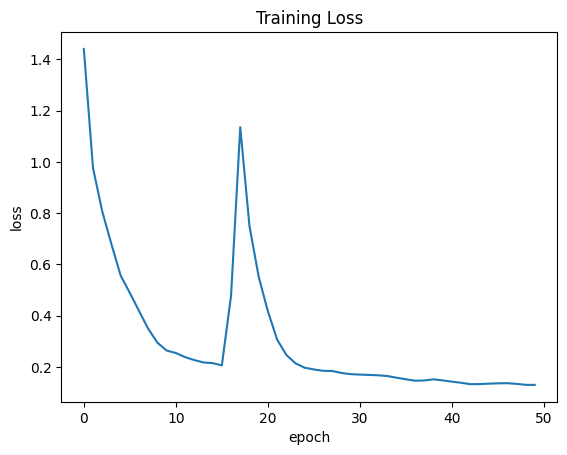

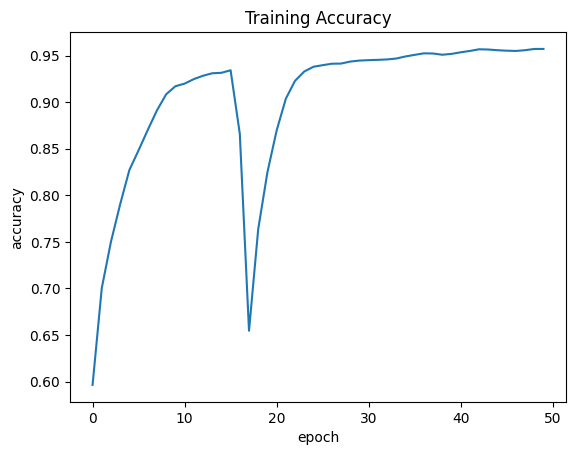

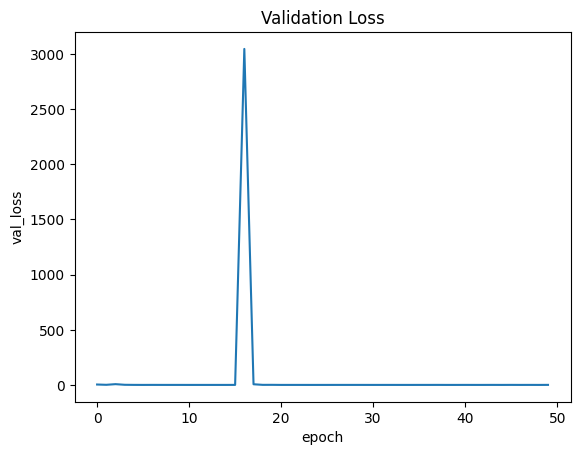

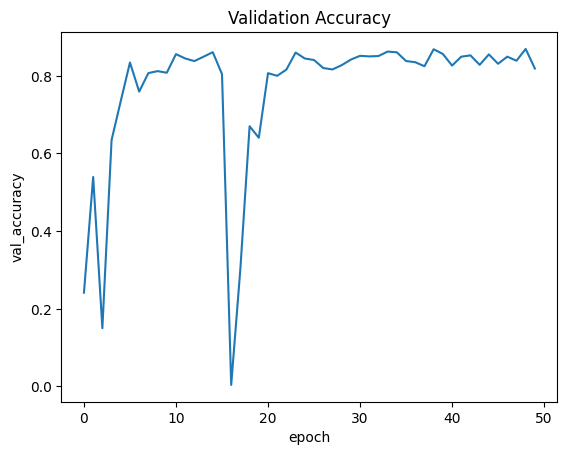

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.save(f"{work_dir}/Deeplabv3+")

In [ ]:
deepy = tf.keras.models.load_model(f"{work_dir}/Deeplabv3+")

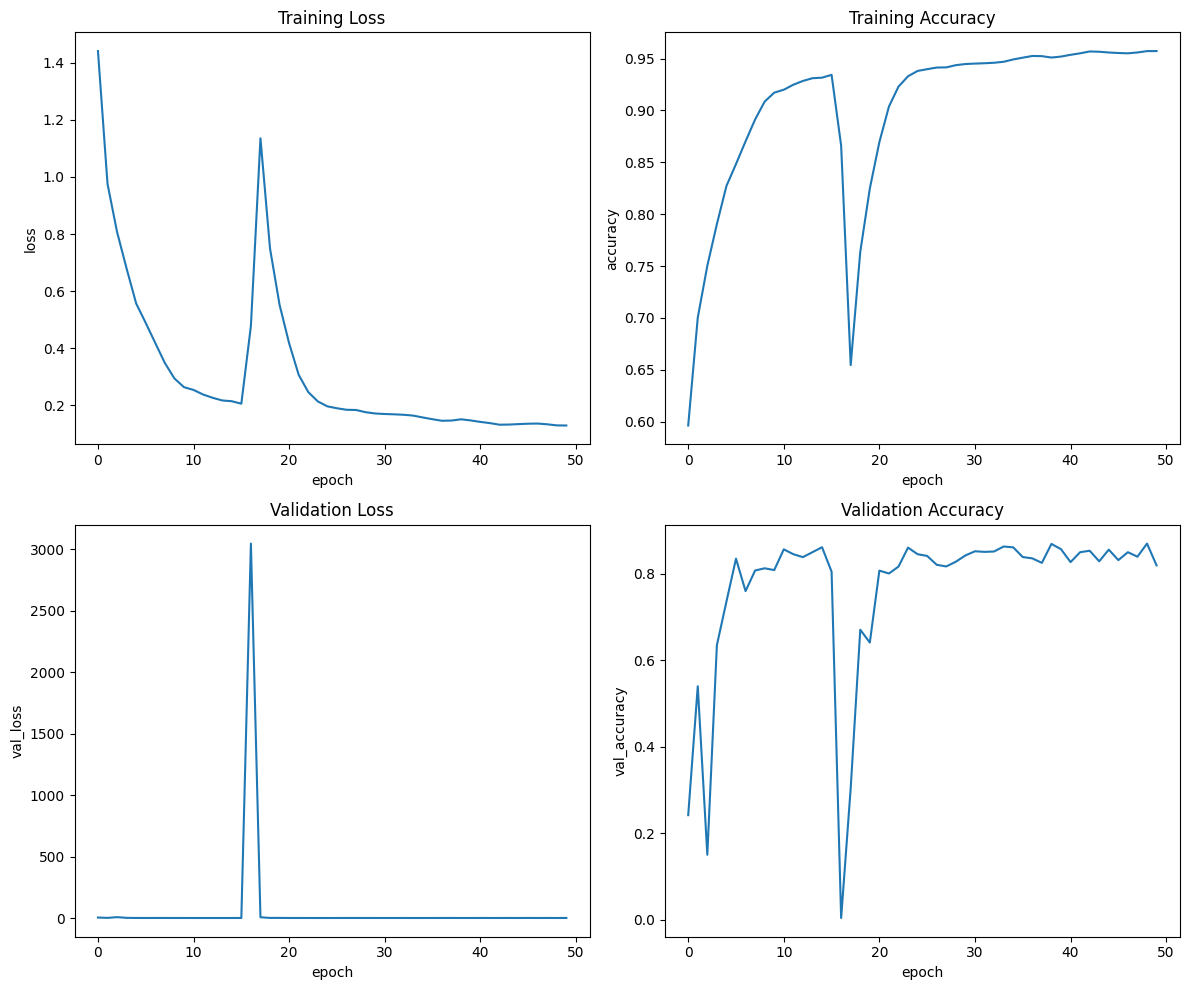

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Subplot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

# Subplot 2: Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")

# Subplot 3: Validation Loss
plt.subplot(2, 2, 3)
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")

# Subplot 4: Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")

plt.tight_layout()  # Adjust subplot parameters for a better layout
plt.show()

In [ ]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, maps_list, colormap, model):
    for image_file, map_file in zip(images_list, maps_list):
        image_tensor = read_image(image_file)
        image = tf.io.read_file(map_file)
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        fig = plt.figure(figsize=(15, 5))  # Adjust the width as needed

# Plot the first image in the first subplot
        plt.subplot(1, 3, 1)
        plt.imshow(tf.keras.utils.array_to_img(image_tensor))
        plt.title('Original Image')

# Plot the second image in the second subplot
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.title('Ground Truth')

# Plot the third image in the third subplot
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_mask)
        plt.title('Predicted')
        #plot_samples_matplotlib(
         #   [image_tensor, prediction_mask], figsize=(18, 14)
        #)

1/1 [==============================] - 0s 43ms/step


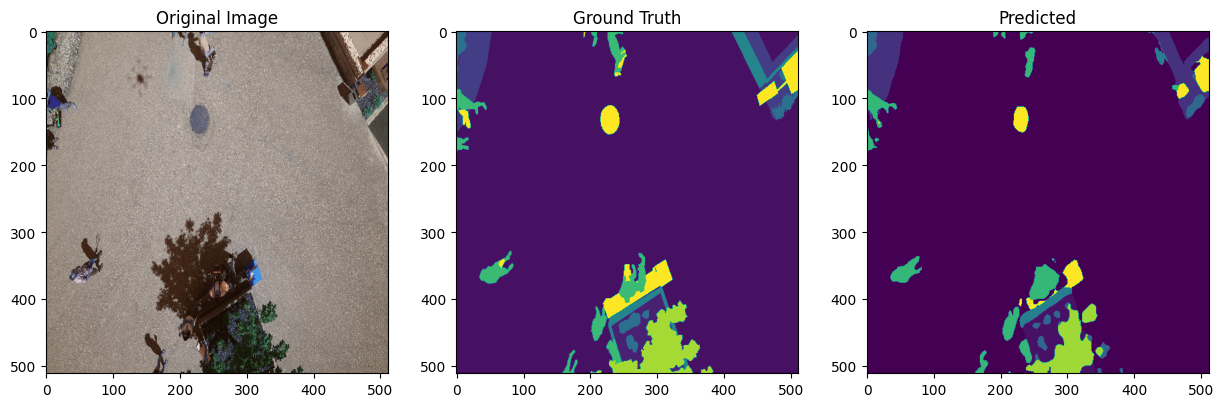

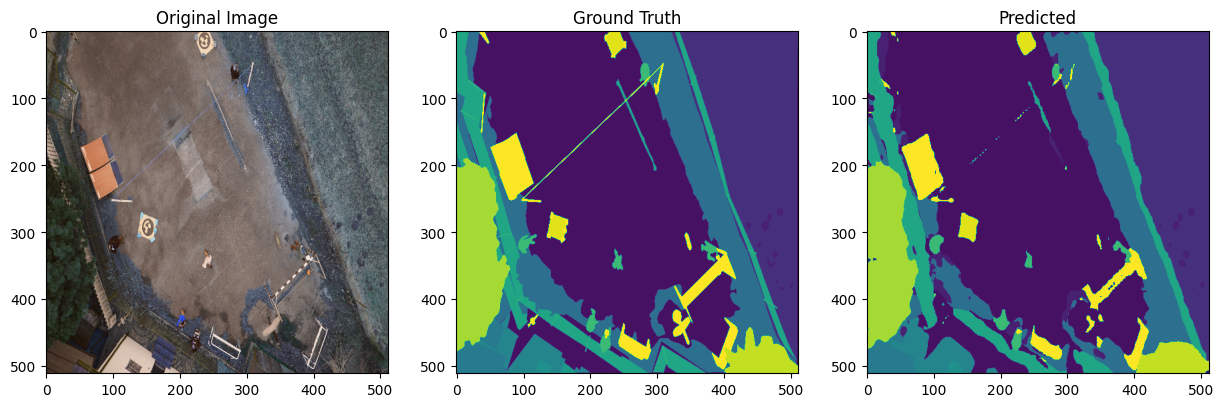

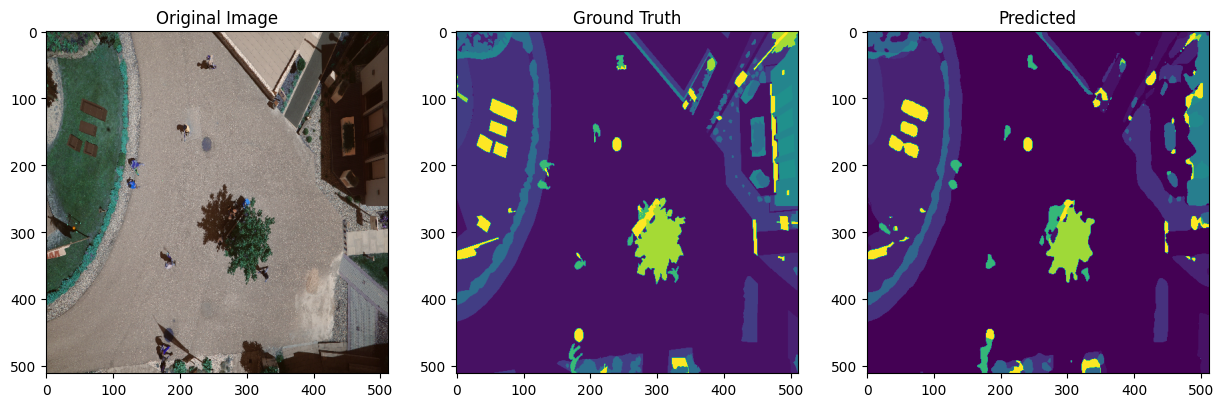

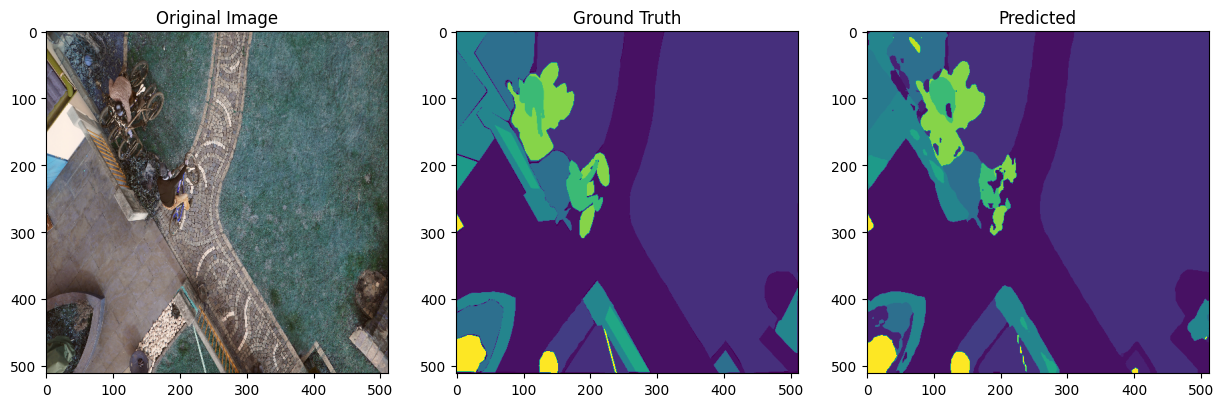

In [ ]:
import pandas as pd
import numpy as np

# Assuming your CSV file is named 'class_colors.csv'
csv_file_path = '/content/drive/MyDrive/DLproject/classdictseg.csv'

# Read CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)
r_column = 'red'
g_column = 'green'
b_column = 'blue'

# Extract values from DataFrame
class_names = df['name'].values
r_values = df[r_column].values
g_values = df[g_column].values
b_values = df[b_column].values
# Create a NumPy array for the colormap
colormap = np.column_stack((r_values, g_values, b_values))
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
plot_predictions(train_images[:4], train_labels[:4], colormap, deepy)

1/1 [==============================] - 0s 26ms/step


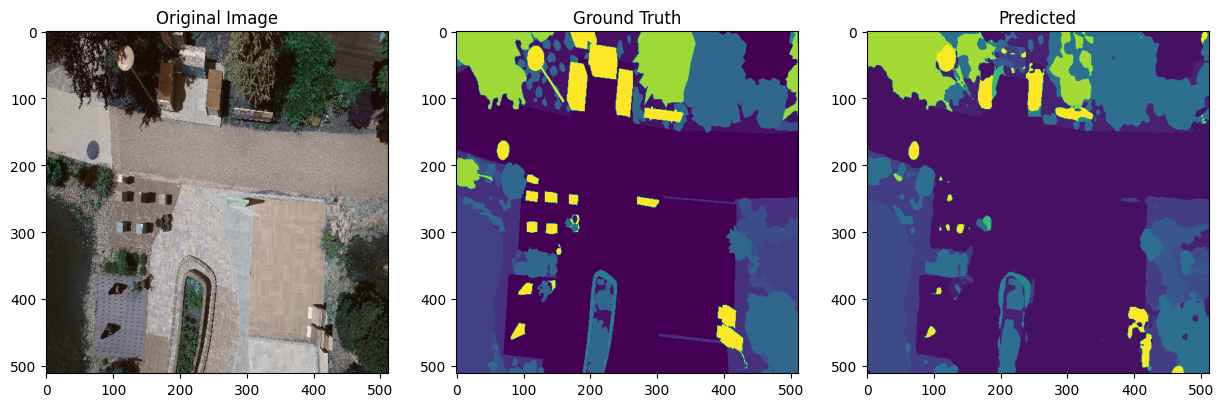

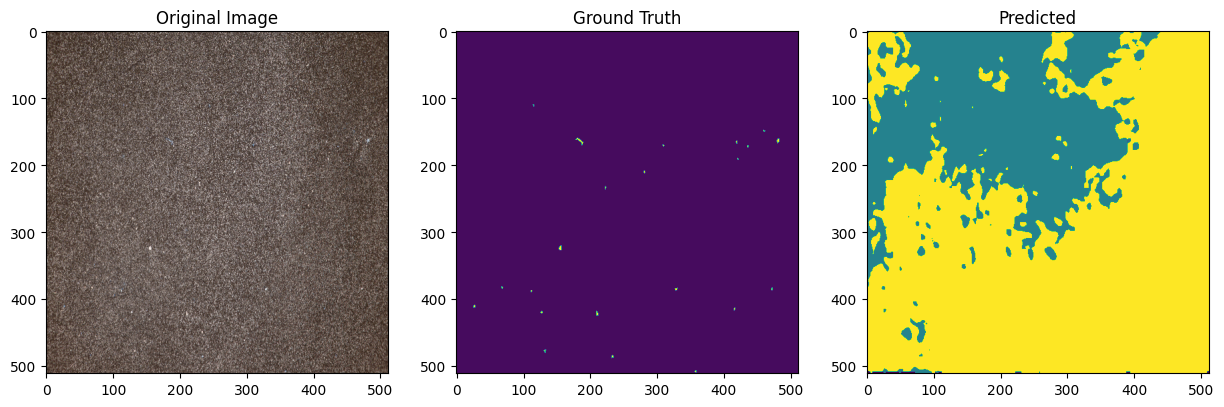

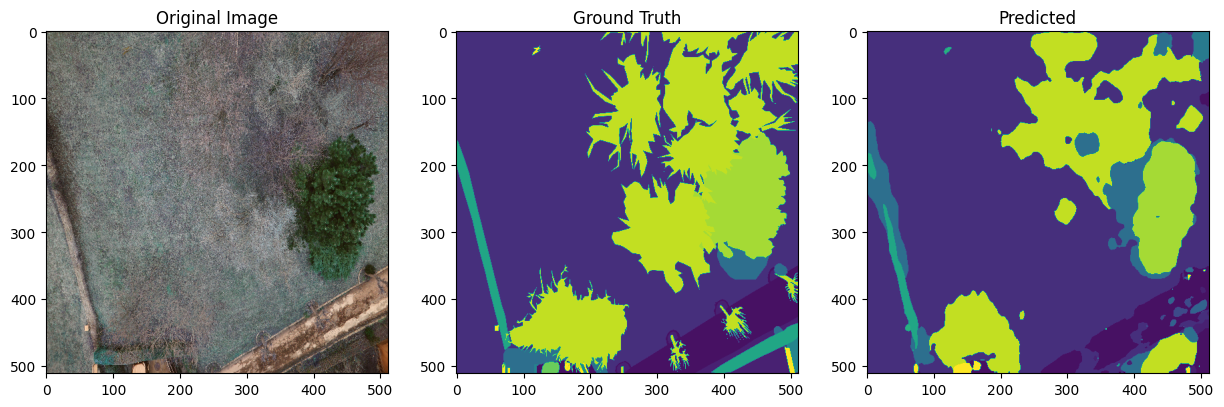

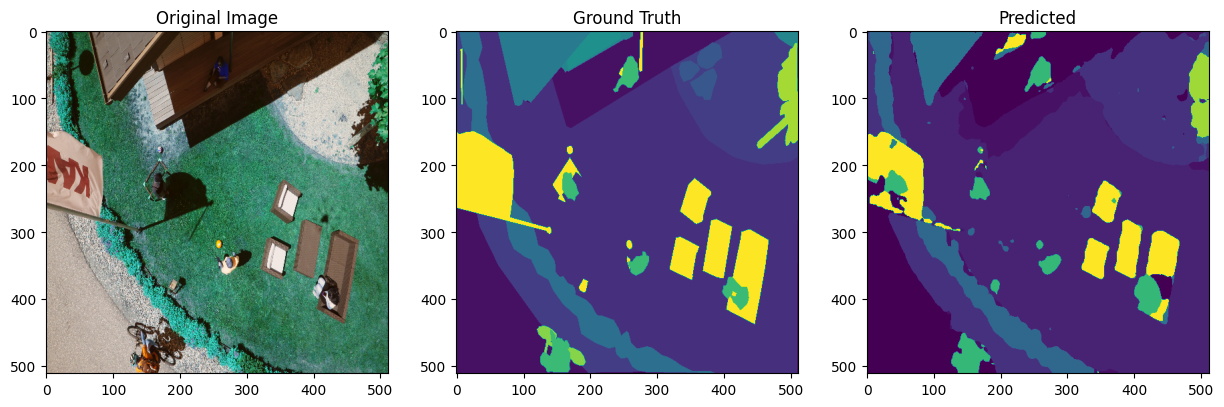

In [ ]:
plot_predictions(val_images[:4], val_labels[:4], colormap, model=model)